<a href="https://colab.research.google.com/github/C-Designer/Codestates_Section_Project/blob/main/Section1_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [43]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns   #색상 지정
import pandas as pd
import numpy as np
from scipy import stats
import math

%matplotlib inline
mpl.rc('axes', unicode_minus=False)
plt.rc('font', family='NanumBarunGothic') 
%config InlineBackend.figure_format='retina'

## 데이터 확인

In [3]:
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv')

df.info() # 16598행 10열

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


In [4]:
df.describe()  # 숫자형 데이터가 Year밖에없다

,Unnamed: 0,Year
count,16598.000000,16327.000000
mean,8299.500000,1994.242543
std,4791.574219,155.077168
min,1.000000,0.000000
25%,4150.250000,2003.000000
50%,8299.500000,2007.000000
75%,12448.750000,2010.000000
max,16598.000000,2020.000000


In [5]:
df.isnull().sum()  # 결측값 확인

Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

## 데이터 전처리
- 결측값 처리
- 금액단위 통합
- 날짜값 이상치 처리

#### 결측값 처리

In [6]:
df = df.iloc[:, 1:] # Unnamed 제거
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


Text(0.5, 1.0, 'Total Missing Value (%)')

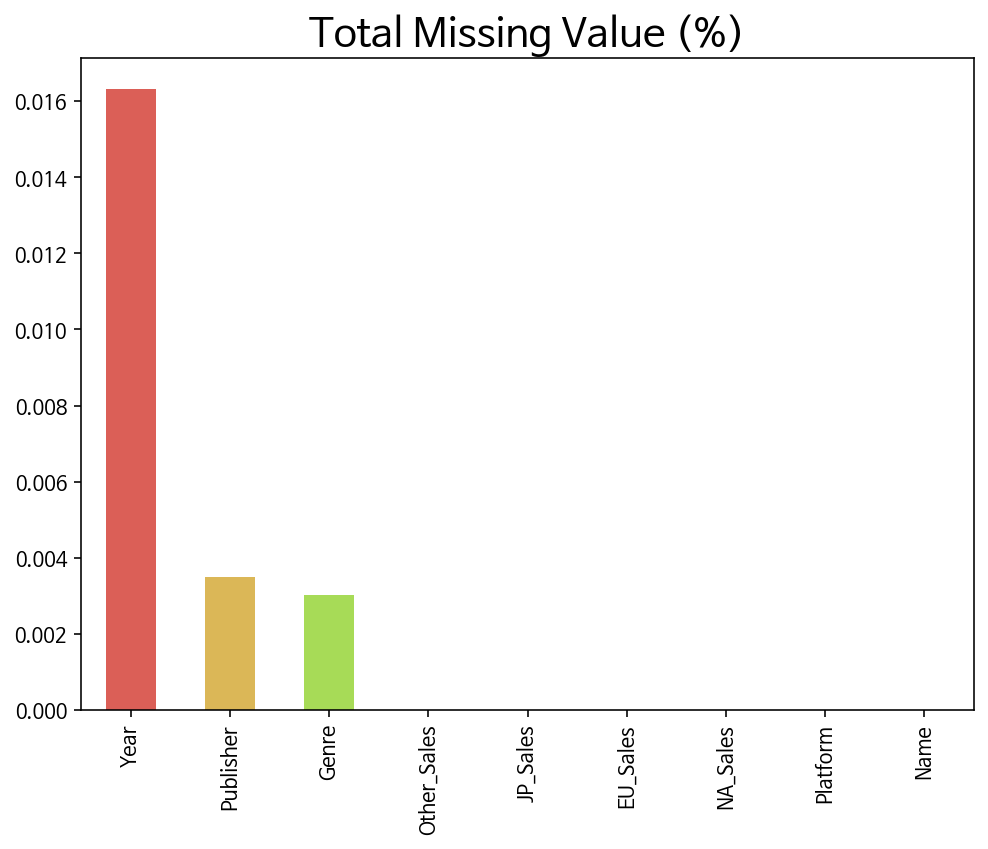

In [7]:
colors = sns.color_palette('hls', 9) #색상 지정
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10, color = colors)

plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

Text(0.5, 1.0, 'Correlation with Missing Values')

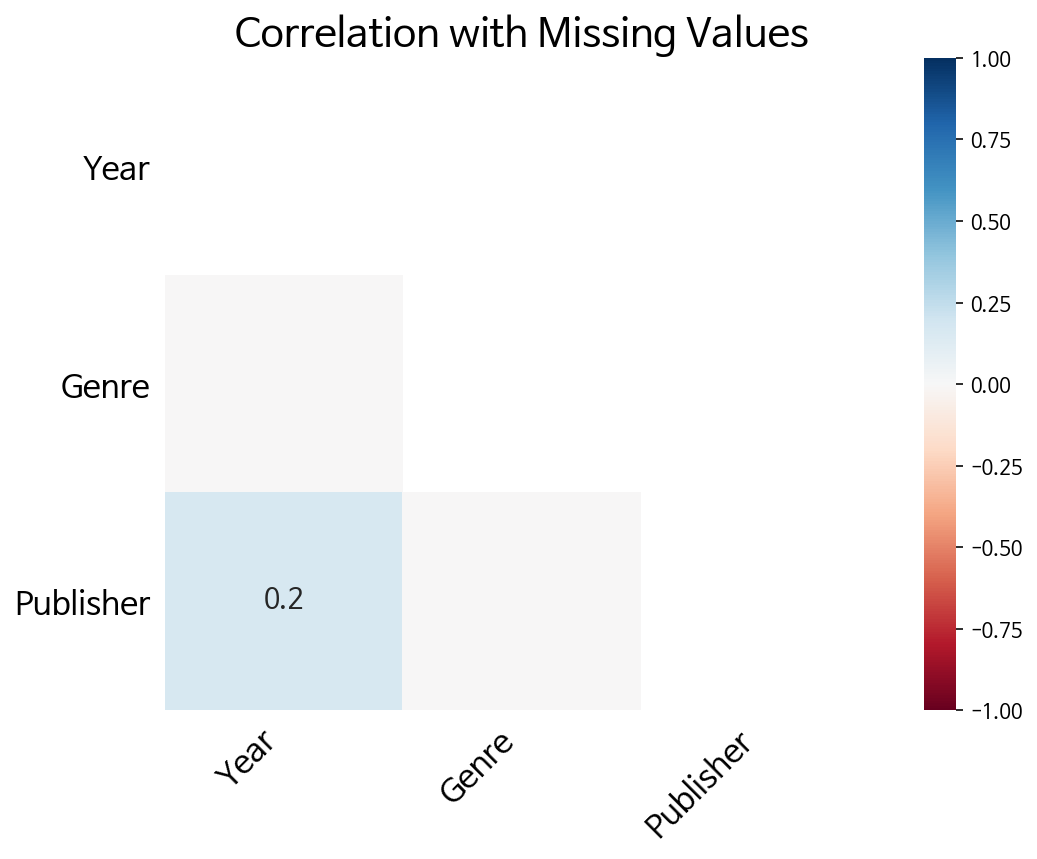

In [8]:
import missingno as msno

missingdata_df = df.columns[df.isnull().any()].tolist()
msno.heatmap(df[missingdata_df], figsize=(8,6))
plt.title("Correlation with Missing Values", fontsize = 20)

In [9]:
df[df['Year'].isnull()].head()
df[df['Publisher'].isnull()].head()
df[df['Genre'].isnull()].head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
50,Ape Escape: On the Loose,PSP,2005.0,NaN,Sony Computer Entertainment,0.52,0.01,0.12,0.05
408,NBA Ballers,XB,2004.0,NaN,Midway Games,0.37,0.11,0,0.02
1328,NFL Street,XB,2004.0,NaN,Electronic Arts,0.49,0.15,0,0.02
1582,SingStar Singalong With Disney,PS2,2008.0,NaN,Sony Computer Entertainment,0,0.04,0,0.57
1971,Pokemon X/Pokemon Y,3DS,2013.0,NaN,Nintendo,5170K,4.05,4.34,0.79


관측치인 결측값중 동일한 기준이 없어 합리적 접근이 불가하다.<br>
날짜값 이상치 처리후 장르와 퍼블리셔 결측값 처리

#### 금액 단위 통합 - M으로 통합, 1K = 0.001M, M은 제거

In [10]:
def Processing_Amount(sales):  # 금액단위 통합 : 단위 추출안될시 반환값 없음

  l = list(sales)              # 금액단위 제거
  unit = l[len(l) -1]
  del l[len(l) -1]

  if unit == 'K':              # 단위가 있을경우 금액 재추출
    sales = float(''.join(l)) * 0.001
  elif unit == 'M':
    sales = float(''.join(l))

  return float(sales) * 1000

In [11]:
sales = (df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
         .applymap(Processing_Amount)
         .astype('int')
         )

df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']] = sales

df['Sum_Sales'] = sales.T.sum()
df['Sum_Sales'] = df['Sum_Sales'].fillna(0)
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sum_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40,0,0,0,40
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,170,0,0,10,180
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,20,0,20
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,40,0,0,0,40
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,120,90,0,40,250
...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,150,40,0,10,200
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,10,0,0,0,10
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,440,190,30,130,790
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,50,50,250,30,380


#### 날짜값 이상치 처리
연도 기준의 표준편차<br>
연도별 - 2자리수 이하 21년을 기준으로 21 이하일시 +2000 / 21 초과일시 +1900

In [12]:
def Processing_Year(year):
  if year < 100:
    if year > 21:
      year += 1900
    else:
      year += 2000
  
  return year

In [13]:
pd.DataFrame(df['Year'].sort_values().head(110)).T

,9276,16394,14666,2249,8681,15612,8144,11163,768,5314,8765,8912,1220,8509,4800,15442,15260,2548,14161,12636,2467,4746,11236,8583,10406,7055,7600,3746,2454,1364,3879,12495,9080,7362,3108,15263,16103,7178,16149,8928,...,10811,12382,10922,8550,4727,6899,15836,5193,7184,7555,304,15447,8191,6192,11263,4010,4365,15985,14785,11334,4839,4807,2429,10705,906,10315,81,14572,3492,16482,10121,5938,7317,14264,5723,13133,15012,12314,9226,16472
Year,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,7.0,7.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,12.0,12.0,13.0,13.0,14.0,14.0,15.0,15.0,15.0,15.0,15.0,16.0,16.0,16.0,16.0,16.0,86.0,94.0,95.0,95.0,95.0,95.0,96.0,96.0,96.0,97.0,97.0,98.0,98.0,98.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1981.0


In [14]:
pd.DataFrame(df['Year'].apply(Processing_Year).sort_values().head(110)).T

,9226,5723,14264,12314,5938,10121,15012,13133,7317,13452,4106,5320,13128,14006,16263,1308,15578,8724,1565,4356,3585,664,5483,1401,1706,4885,16210,13506,9109,1514,5072,1382,1655,6871,8323,14984,877,14673,2618,16472,...,4702,4444,11259,16317,3833,2661,2792,10125,15215,3910,14316,7593,10306,13287,13548,13361,3552,13358,3000,2519,7813,10658,5169,466,10657,12322,6892,10825,15283,12191,6027,10570,12921,6499,6104,10081,16363,4310,4100,37
Year,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,...,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1984.0,1984.0


In [15]:
df['Year'] = df['Year'].apply(Processing_Year)

In [16]:
df = df.sort_values('Year').reset_index()
del df['index']

In [17]:
df = df.dropna()
df.isna().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
Sum_Sales      0
dtype: int64

## 요구조건 조사
1. 지역에 따라서 선호하는 게임 장르가 다를까
2. 연도별 게임의 트렌드가 있을까
3. 매출이 높은 게임에 대한 분석 및 시각화 프로세스

#### 지역에 따라서 선호하는 게임 장르가 다를까
가정 - 매출이 높으면 선호도가 높을 것<br>
<br>
귀무가설 - 지역과 선호장르는 관련이 있다.<br>
대안가설 - 지역과 선호장르는 관련이 없다.

In [89]:
#sales = df.groupby('Genre').sum().sort_values('NA_Sales')
#sales = sales.iloc[:, 1:5]

chi2, p, dof, expected = stats.chi2_contingency(sales, correction= True)

sales

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Strategy,67830,44820,49100,11230
Adventure,101790,63660,51870,16700
Puzzle,121580,50470,56240,12440
Simulation,181428,112990,63540,31320
Fighting,220348,99900,87140,36150
Role-Playing,318760,183090,342930,56730
Racing,354698,235020,56320,76510
Misc,394730,208150,104180,72640
Platform,445380,200630,130530,51450


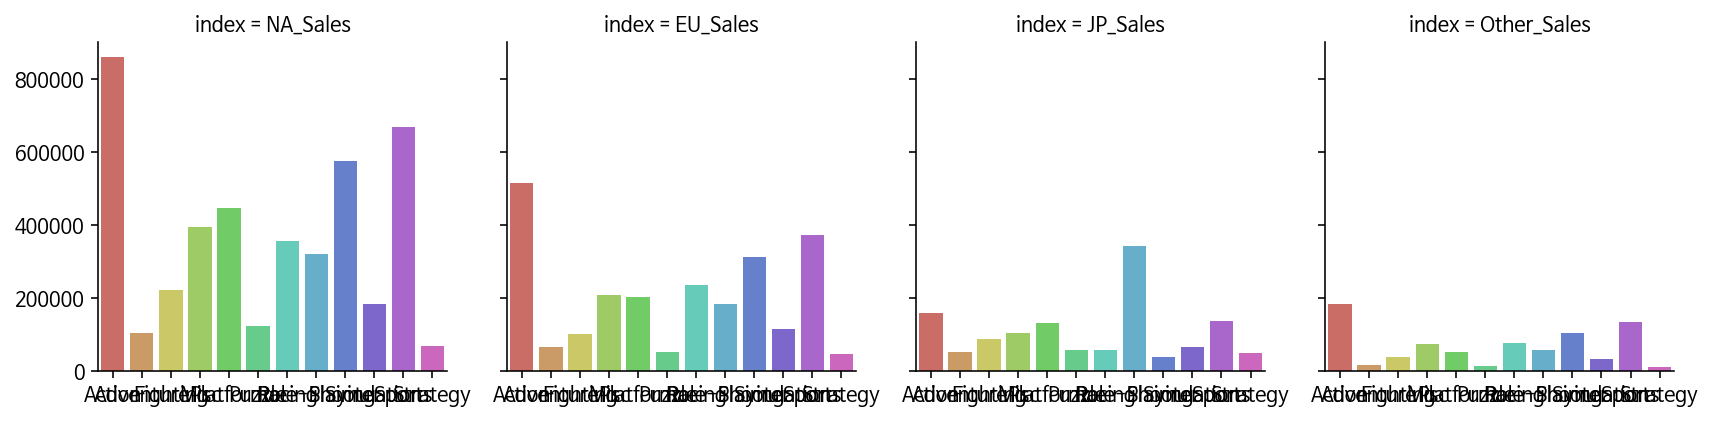

In [18]:
Genre_Sales = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
Genre_Sales = Genre_Sales.groupby('Genre').sum()

location = Genre_Sales.T.reset_index()
colors = sns.color_palette('hls', len(location.T))

g = sns.FacetGrid(data = location, col = 'index') # col이 아니라 row 로도 실행해보세요.

g.map_dataframe(
    sns.barplot,
    palette = colors,
    data = location
)

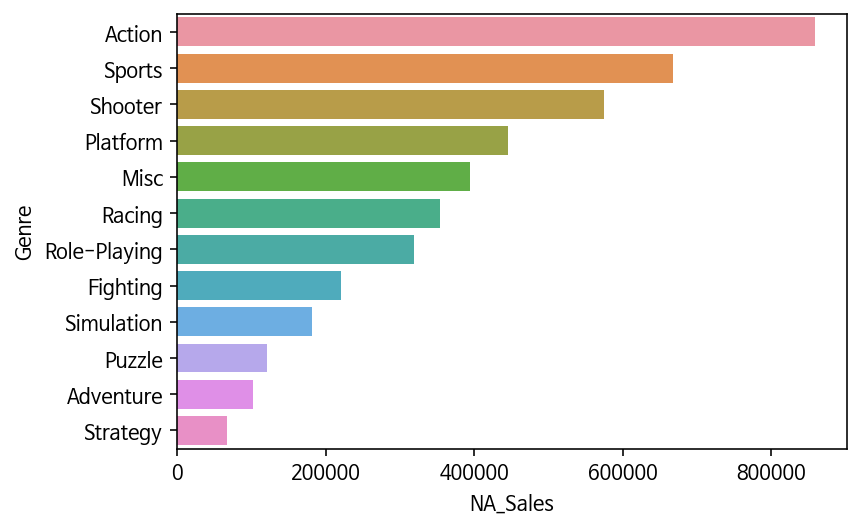

In [19]:
# 북미 매출액
NA_Genre = Genre_Sales['NA_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'NA_Sales', data= NA_Genre)

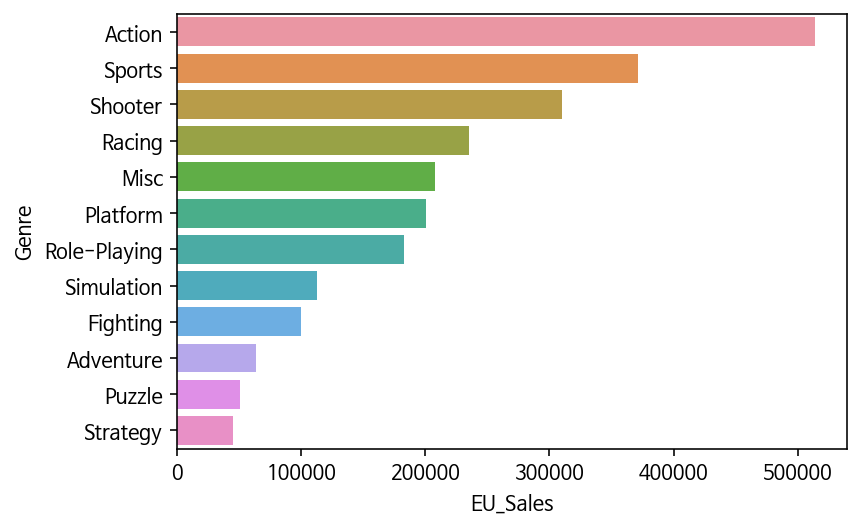

In [20]:
# 유럽 매출액
EU_Genre = Genre_Sales['EU_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'EU_Sales', data= EU_Genre)

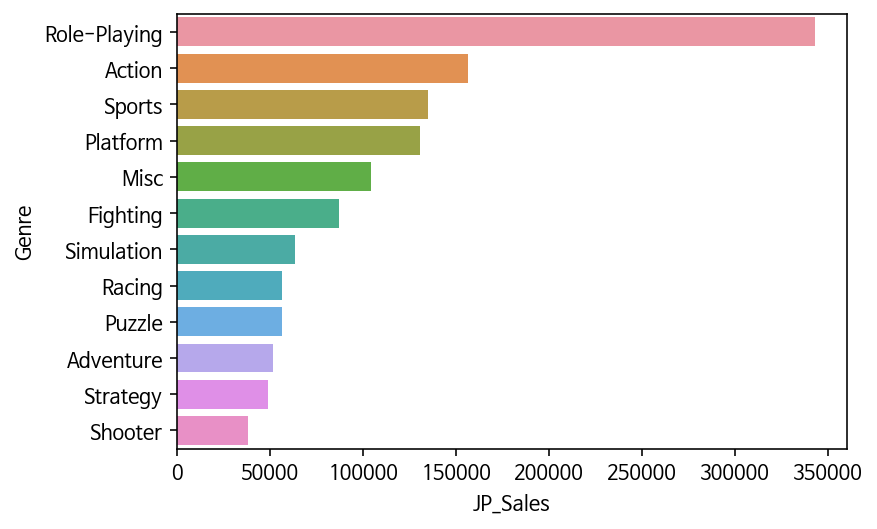

In [21]:
# 일본 매출액
JP_Genre = Genre_Sales['JP_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'JP_Sales', data= JP_Genre)

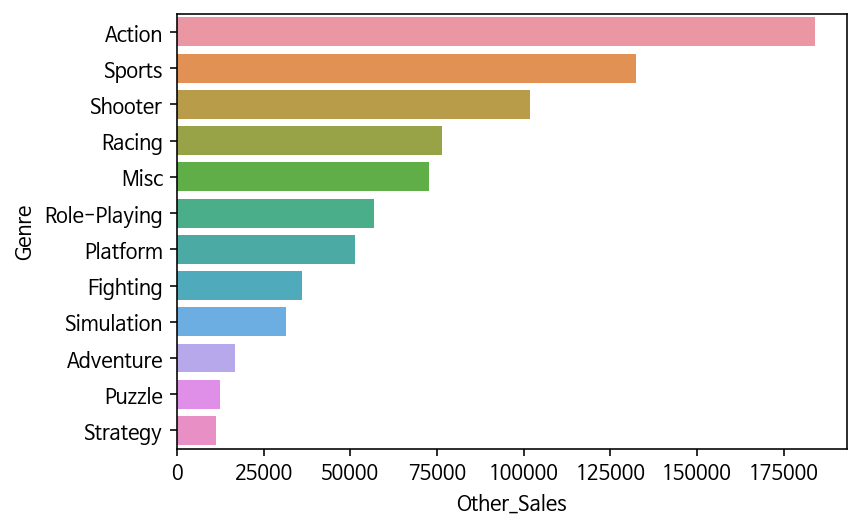

In [22]:
# 기타지역 매출액
Other_Genre = Genre_Sales['Other_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'Other_Sales', data= Other_Genre)

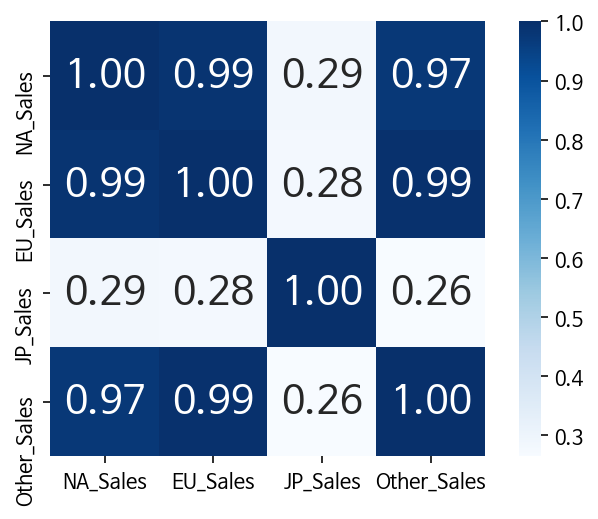

In [23]:
corr = Genre_Sales.corr(method= 'pearson')

sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

  통계적 수치에 따른 장르별 매출 순위
  - 북미 : Platform, Shooter, Racing ...
  - 유럽 : Shooter, Platform, Racing ...
  - 일본 : Role-Playing, Platform, Fighting ...
  - 기타 : Shooter, Racing, Platform ...

  신기하게도 피어슨 상관계수를 사용하여 상관분석을 해본결과<br>
  일본빼곤 정도의 차이이지 다들 비슷한 결과가 나왔다

#### 연도별 게임의 트렌드
연간 장르별 최다 출시 장르<br>
연간 장르별 매출 합산후 최고매출 장르<br>
연간 장르별 매출평균 중 최고매출 장르

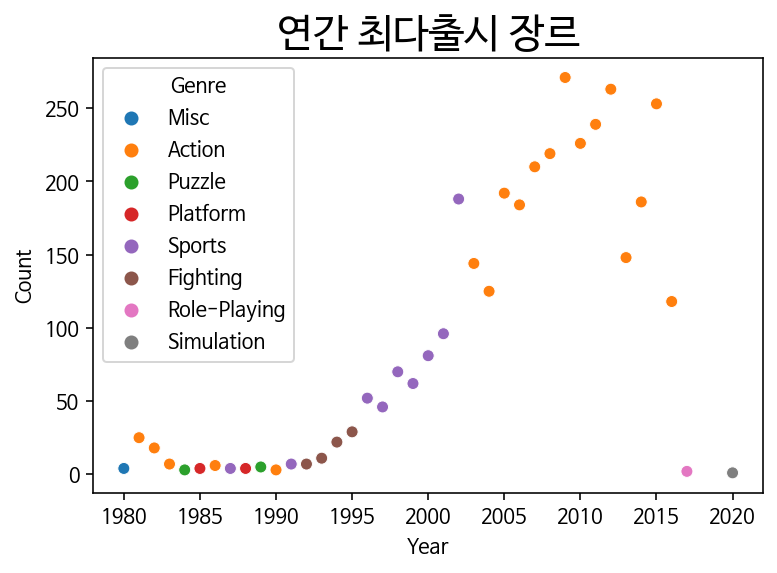

In [25]:
# 연간 게임 최다 출시갯수 장르
trend = df.groupby(['Year', 'Genre']).count().iloc[:, 1]
trend = trend.loc[trend.groupby('Year').idxmax()].to_frame().reset_index()
trend.columns = ['Year', 'Genre', 'Count']

plt.title('연간 최다출시 장르', fontsize= 20)
sns.scatterplot(x= 'Year', y= 'Count', hue= 'Genre', data= trend)

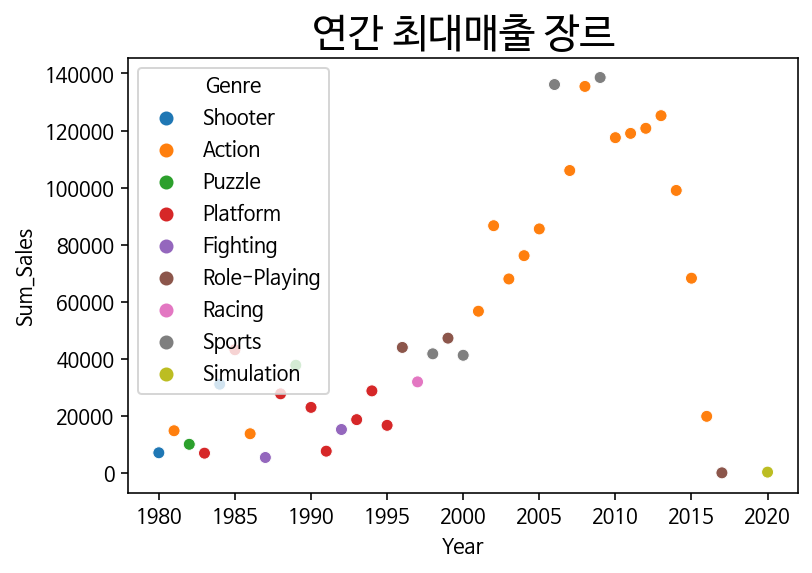

In [26]:
# 연간 장르별 매출 합산후 최고매출 장르
sum = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).sum() # 연도별 장르끼리 합치기
sum = sum.loc[sum.groupby('Year')['Sum_Sales'].idxmax()] # 연도별 매출 가장큰 장르 추출

plt.title('연간 최대매출 장르', fontsize= 20)
sns.scatterplot(x= 'Year', y= 'Sum_Sales', hue= 'Genre', data= sum)

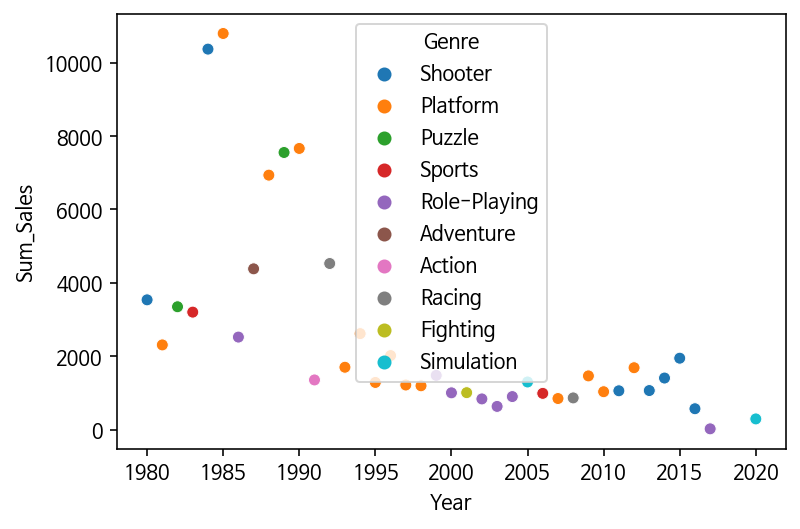

In [27]:
# 연간 장르별 매출평균 중 최고매출 장르
mean = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).mean() # 연도별 장르끼리 합치기
mean = mean.loc[mean.groupby('Year')['Sum_Sales'].idxmax()] # 연도별 매출 가장큰 장르 추출

sns.scatterplot(x= 'Year', y= 'Sum_Sales', hue= 'Genre', data= mean)

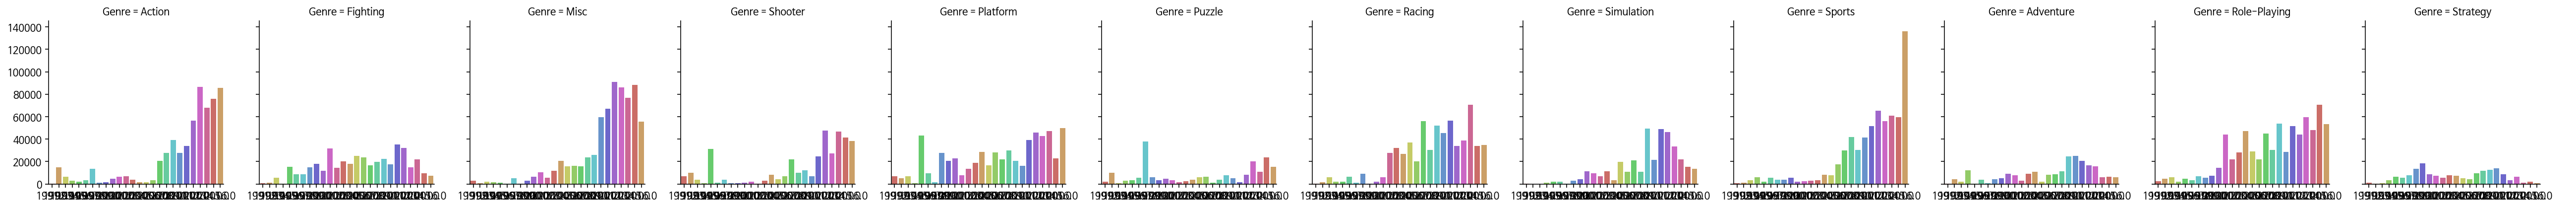

In [28]:
# 장르별 연간 매출

Genre = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).sum().reset_index()

g = sns.FacetGrid(data = Genre, col = 'Genre')
colors = sns.color_palette('hls', len(df['Genre'].unique()))

g.map_dataframe(
    sns.barplot,
    x = 'Year',
    y = 'Sum_Sales',
    data = Genre,
    palette = colors
)
g.add_legend();

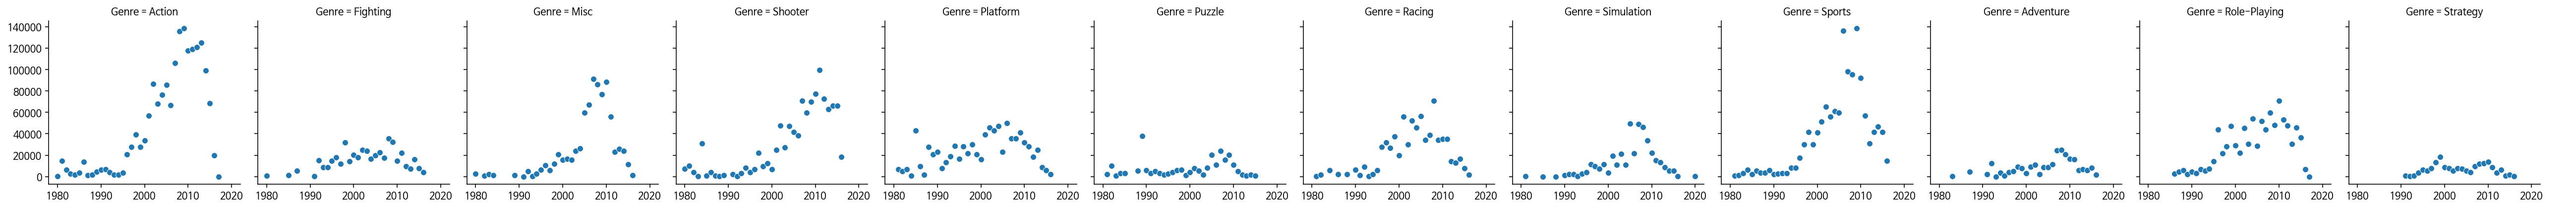

In [29]:
Genre = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).sum().reset_index()

g = sns.FacetGrid(data = Genre, col = 'Genre')
colors = sns.color_palette('hls', len(df['Genre'].unique()))

g.map_dataframe(
    sns.scatterplot,
    x = 'Year',
    y = 'Sum_Sales',
    data = Genre,
    palette = colors
)
g.add_legend();

  트렌드의 기준을 무엇으로 둬야할지 애매해서 나누어 분석하였다<br>
  - 연간 장르별 최다 출시 장르
  - 연간 장르별 매출 합산후 최고매출 장르
  - 연간 장르별 매출평균 중 최고매출 장르
  - 장르별 연간매출
  
  2000년을 기점으로 액션, 스포츠 장르가 주축을 이루는 것으로 보인다<br>
  장르별 연간 매출을 조사해본 결과 콘솔게임 시장의 급격한 매출감소를 제외한다면<br>
  스포츠, 액션, role-playing은 상향곡선을 그리고 있다.

#### 매출이 높은 게임에 대한 분석 및 시각화 프로세스

In [30]:
# 매출 상위 1%
top_Game = df.sort_values('Sum_Sales', ascending= False).iloc[:int(len(df) * 0.01)]
top_Game = top_Game[['Name','Platform', 'Genre', 'Publisher', 'Sum_Sales']]
top_Game

,Name,Platform,Genre,Publisher,Sum_Sales
6438,Wii Sports,Wii,Sports,Nintendo,82740
130,Super Mario Bros.,NES,Platform,Nintendo,40240
8389,Mario Kart Wii,Wii,Racing,Nintendo,35830
10266,Wii Sports Resort,Wii,Sports,Nintendo,33000
906,Pokemon Red/Pokemon Blue,GB,Role-Playing,Nintendo,31380
...,...,...,...,...,...
12914,Batman: Arkham City,PS3,Action,Warner Bros. Interactive Entertainment,5520
9726,Monster Hunter Freedom Unite,PSP,Role-Playing,Capcom,5510
2468,Super Mario Advance,GBA,Platform,Nintendo,5490
2804,Mario Kart: Super Circuit,GBA,Racing,Nintendo,5480


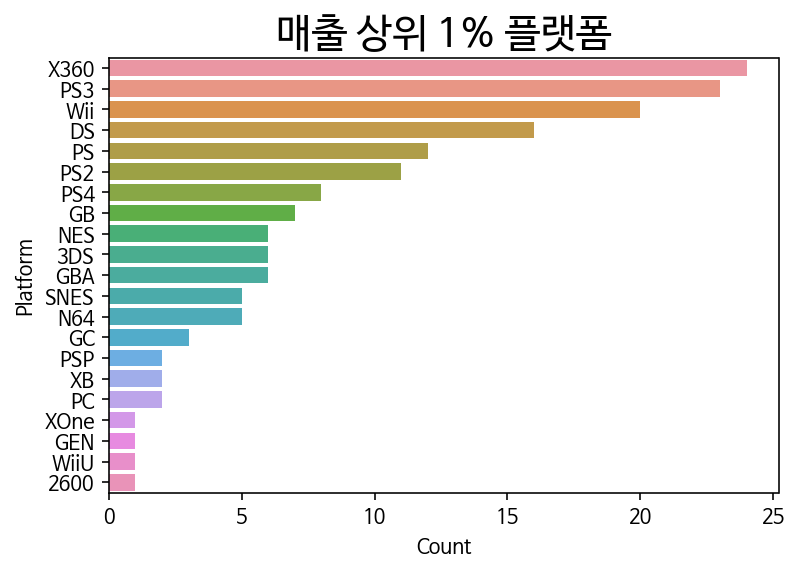

In [90]:
# 매출 상위 1% 플랫폼비율
top_Platform = (top_Game.groupby('Platform').count()  # 카운팅
  .iloc[:, 1]   # 관련없는 열 제거
 .sort_values(ascending= False)  # 내림차순
 .reset_index()
 )

top_Platform.columns = ['Platform', 'Count']

plt.title('매출 상위 1% 플랫폼', fontsize= 20)
sns.barplot(x= 'Count', y= 'Platform', data= top_Platform)

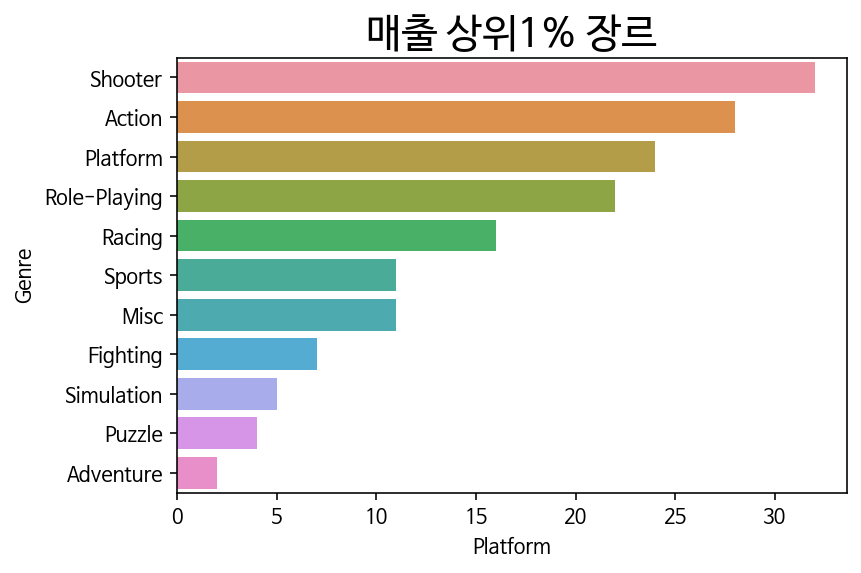

In [91]:
# 상위 1% 장르비율
top_Genre = top_Game.groupby('Genre').count().iloc[:, 1].sort_values(ascending= False).reset_index()

plt.title('매출 상위1% 장르', fontsize= 20)
sns.barplot(x= 'Platform', y= 'Genre', data= top_Genre)

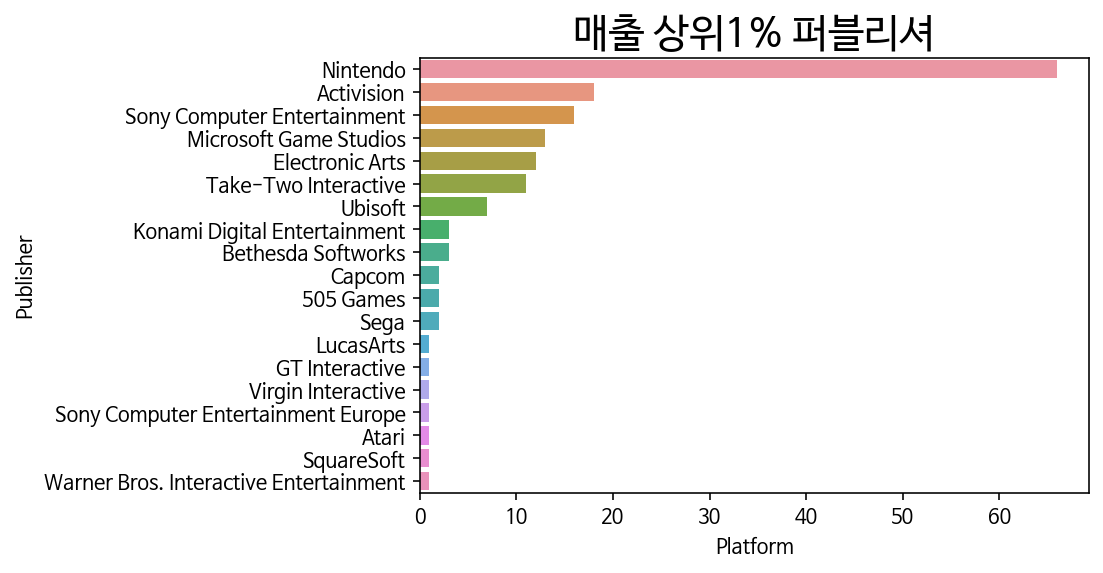

In [92]:
# 상위 1% 퍼블리셔비율
top_Publisher = top_Game.groupby('Publisher').count().iloc[:, 1].sort_values(ascending= False).reset_index()

plt.title('매출 상위1% 퍼블리셔', fontsize= 20)
sns.barplot(x= 'Platform', y= 'Publisher', data= top_Publisher)

  매출상위 1%를 기준으로 나열한 순위이다
  - 플랫폼 비율 : x360, PS3, Wii, DS ..
  - 장르 비율 : Shooter, Action, Platform, Role_Playing ..
  - 퍼블리셔 비율 : Nintendo, Activision, Sony .. 


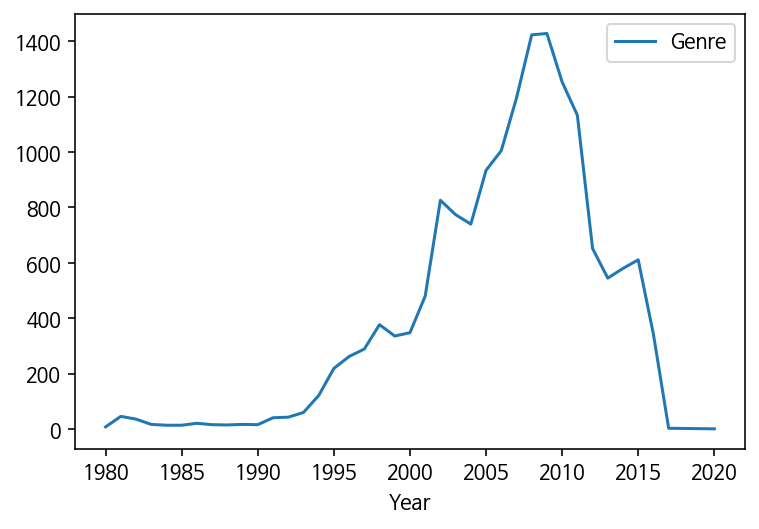

In [34]:
# 연도별 데이터 분량

count_by_years = df[['Year', 'Genre']].groupby('Year').count()
count_by_years.plot()

그래프 상으론 PC, 모바일 시장의 확장에 의한 영향을 받은것으로 보기엔 묘하게 이질감이 든다 <br>
PC,모바일 게임시장이 대폭확장되며 영향을 받은건 사실이지만 <br>
콘솔 게임시장이 너무 극단적으로 축소된 느낌이 없지않다.<br>
검색만해봐도 근래에 들어 콘솔게임의 시장은 오히려 상승세라는 말이 자자하다<br>
<br>
아래와 같이 해외에선 모바일 다음으로 큰시장이 콘솔게임이다

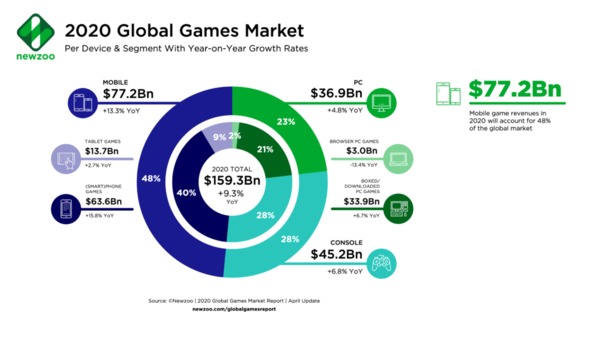

근래에 코로나 여파에 더불어 세계시장은 물론 <br>
국내시장도 빠르게 확장되고 있는걸 알수있다

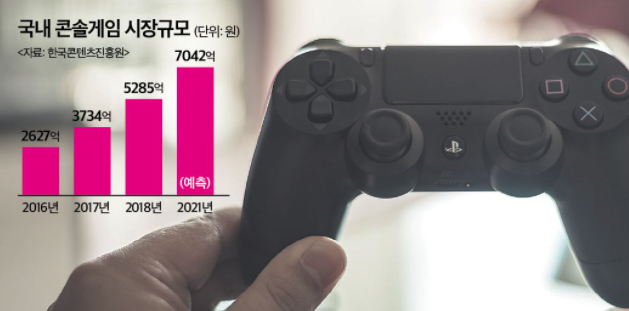

'배틀그라운드', '테라' 등 기존 게임 IP(지적재산권)의 콘솔버전 출시를 앞다투어 하고있다.

In [35]:
# 연도별 데이터수의 표준편차
np.std(count_by_years)

Genre    443.665027
dtype: float64

해당 시장 점유율 및 표준편차를 생각해봤을때<br> 현재 데이터 셋은 연도별로 고르게 샘플링을 하지못했다고 볼 수 있다.<br>
적어도 2016년도 이후만큼은.

In [36]:
# 분포가 이상하여 뒷부분을 확인해보았다
df.tail()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sum_Sales
16322,Terraria,3DS,2016.0,Action,505 Games,0,30,40,0,70
16323,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2017.0,Role-Playing,Sega,0,0,10,0,10
16324,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0,0,10,0,10
16325,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0,0,30,0,30
16326,Imagine: Makeup Artist,DS,2020.0,Simulation,Ubisoft,270,0,0,20,290


In [37]:
# 연도 기입이 올바르지 않은 게임 / 아래 순서로 2014, 2012, 2012, 2012, 2009 순이다

df.loc[[16322, 16323, 16324, 16325, 16326], 'Year'] = [2014.0, 2012.0, 2012.0, 2012.0, 2009.0]
df.tail()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sum_Sales
16322,Terraria,3DS,2014.0,Action,505 Games,0,30,40,0,70
16323,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2012.0,Role-Playing,Sega,0,0,10,0,10
16324,Brothers Conflict: Precious Baby,PSV,2012.0,Action,Idea Factory,0,0,10,0,10
16325,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2012.0,Role-Playing,Sega,0,0,30,0,30
16326,Imagine: Makeup Artist,DS,2009.0,Simulation,Ubisoft,270,0,0,20,290


1. 주제 : 다음 분기에 어떤 게임을 설계해야 할까요?
2. 대상 : 비데이터 직군
3. 목표 : 해당 주제에 대한 분석 설명 영상(5분) 발표를 통한 분석정보 전달
4. 필수분석 내용<br>
  1) 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.<br>
  2) 연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.<br>
  3) 매출이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.<br>

In [38]:
# 데이터셋의 근 3년확인
df['Year'].unique()

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.])

In [39]:
#df.loc[df['Year'] == ['2014', '2015', '2016']]

In [40]:
df.groupby(['Name']).sum()['Sum_Sales'].sort_values(ascending = False)

Name
Wii Sports                                                 82740
Grand Theft Auto V                                         55919
Super Mario Bros.                                          45310
Tetris                                                     35840
Mario Kart Wii                                             35830
                                                           ...  
Cities: Skylines Snowfall                                     10
Imagine Figure Skater (JP sales)                              10
The Dark Hills of Cherai                                      10
Chou Ezaru wa Akai Hana: Koi wa Tsuki ni Shirube Kareru       10
Dynasty Warriors: Eiketsuden                                  10
Name: Sum_Sales, Length: 11295, dtype: int64

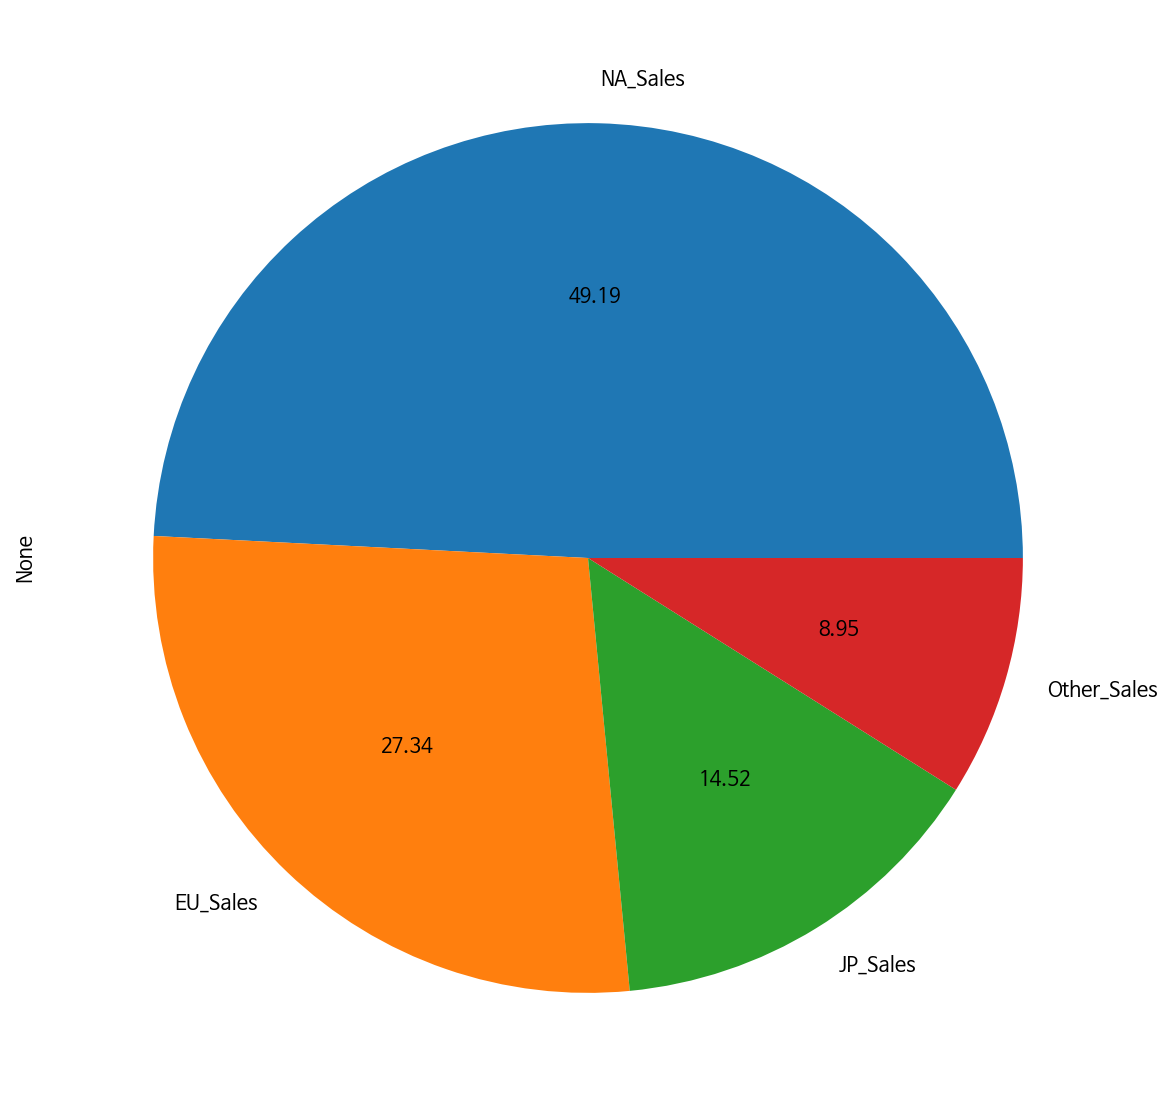

In [24]:
# 지역별 시장크기
Genre_Sales.sum().plot(kind='pie', figsize=(10, 10), autopct='%.2f')

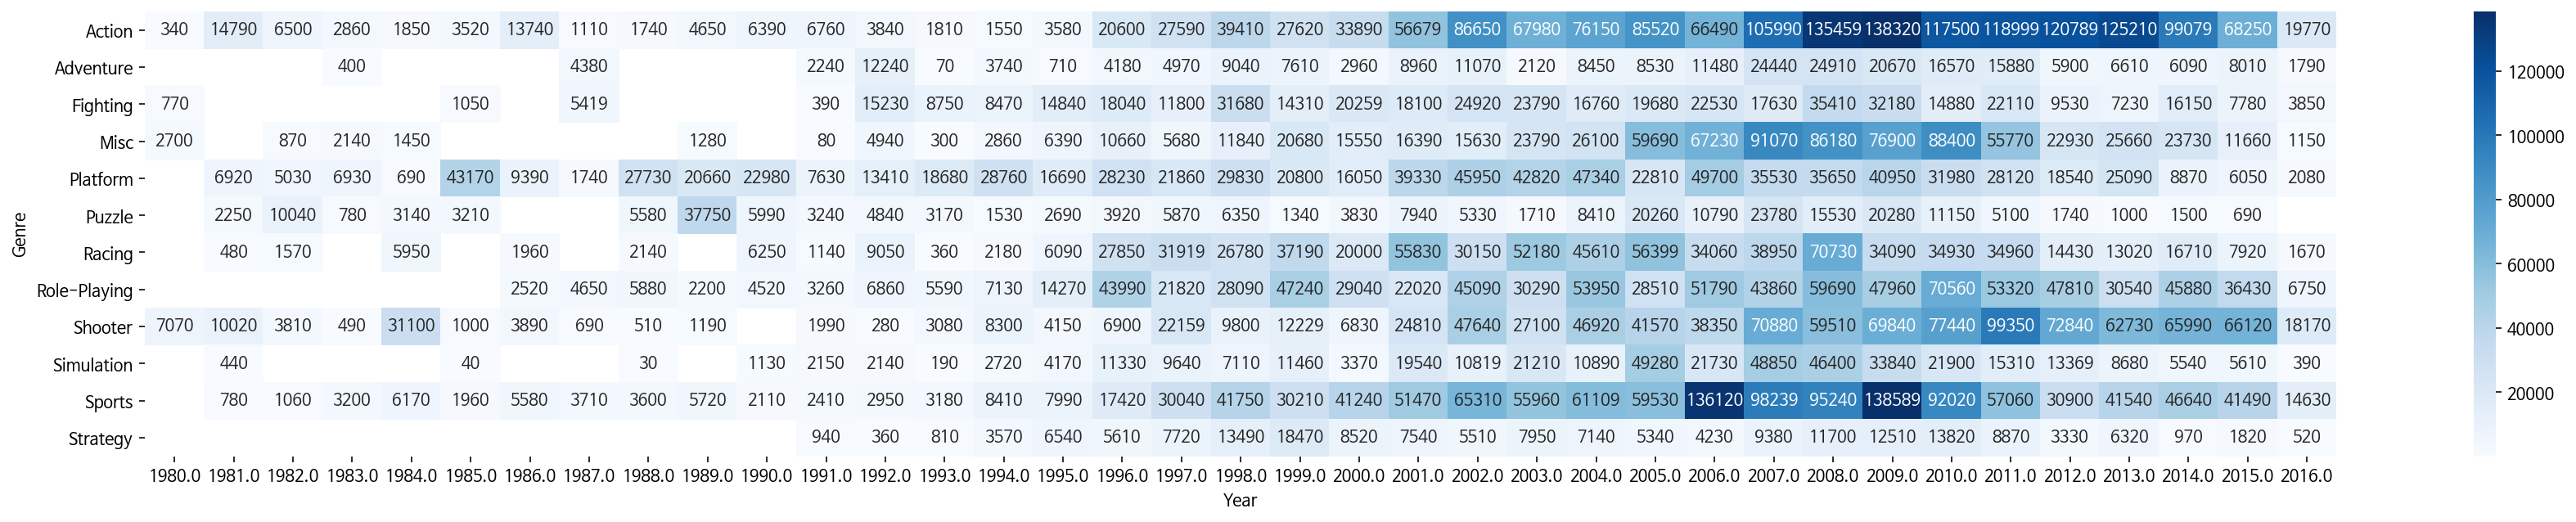

In [41]:
year_Genre = pd.pivot_table(df[['Year', 'Genre', 'Sum_Sales']], index = 'Year',columns = 'Genre', values = 'Sum_Sales', aggfunc = 'sum')

plt.figure(figsize=(30,5))
sns.heatmap(year_Genre.T ,annot = True, fmt = '.0f', cmap = 'Blues')